In [1]:
# importing required dependencies
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score,accuracy_score,classification_report
import seaborn as sns
seed(1)

In [2]:
# importing the 90 days aggregated california dataset
cal_90d_agg = pd.read_csv('drought dataset/ninety_days_aggregated_data_ca_drought.csv')

# drop unnecessary column
cal_90d_agg = cal_90d_agg.drop(columns=['Unnamed: 0'])

# view the first 5 rows of the dataset
cal_90d_agg.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,6001.0,0.196000,100.487000,5.158000,7.692000,3.782000,3.810000,13.969000,3.687000,10.283000,7.392000,2.666000,4.207000,1.488000,2.719000,4.001000,5.938000,2.173000,3.766000,0.6079
1,6001.0,1.709412,100.257059,5.701765,8.592941,5.245294,5.262941,14.011176,4.871765,9.138824,8.114706,2.854706,4.770588,1.411765,3.357647,4.334118,6.690000,2.225294,4.465294,0.5036
2,6001.0,5.068333,100.105833,6.274583,9.290833,6.589167,6.601667,14.182917,5.894167,8.288750,8.776250,2.808750,4.680000,1.409583,3.270417,4.319583,6.540833,2.277500,4.263333,0.0000
3,6001.0,4.312581,100.076129,6.227097,9.242903,6.543226,6.553871,14.189677,5.745484,8.443871,8.753548,2.783871,4.532903,1.407419,3.124839,4.286129,6.458065,2.277419,4.180968,0.0000
4,6001.0,3.762632,100.067105,6.358947,9.557368,6.895263,6.903947,14.776316,5.984211,8.791579,8.990000,2.743158,4.506579,1.361316,3.144474,4.222368,6.416842,2.210263,4.207105,0.0000


In [3]:
# store the features in a separate dataframe
X = cal_90d_agg.drop(columns = ['fips','score'])

# view the features dataframe
X.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
0,0.196000,100.487000,5.158000,7.692000,3.782000,3.810000,13.969000,3.687000,10.283000,7.392000,2.666000,4.207000,1.488000,2.719000,4.001000,5.938000,2.173000,3.766000
1,1.709412,100.257059,5.701765,8.592941,5.245294,5.262941,14.011176,4.871765,9.138824,8.114706,2.854706,4.770588,1.411765,3.357647,4.334118,6.690000,2.225294,4.465294
2,5.068333,100.105833,6.274583,9.290833,6.589167,6.601667,14.182917,5.894167,8.288750,8.776250,2.808750,4.680000,1.409583,3.270417,4.319583,6.540833,2.277500,4.263333
3,4.312581,100.076129,6.227097,9.242903,6.543226,6.553871,14.189677,5.745484,8.443871,8.753548,2.783871,4.532903,1.407419,3.124839,4.286129,6.458065,2.277419,4.180968
4,3.762632,100.067105,6.358947,9.557368,6.895263,6.903947,14.776316,5.984211,8.791579,8.990000,2.743158,4.506579,1.361316,3.144474,4.222368,6.416842,2.210263,4.207105


In [4]:
# store the drought intensity labels in a separate dataframe
y = cal_90d_agg['score'].round()

# view the first 5 rows of the labels dataframe
print(y.head())

# view the occurences of different labels
print(y.value_counts())

0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: score, dtype: float64
0.0    27785
1.0    10371
2.0     9985
3.0     7722
4.0     3911
5.0     3794
Name: score, dtype: int64


In [11]:
y_bp_df = pd.DataFrame(y.value_counts())
y_bp_df1 = y_bp_df.reset_index()
y_bp_df1['intensity'] = y_bp_df1['index']
print(y_bp_df1)

   index  score  intensity
0    0.0  27785        0.0
1    1.0  10371        1.0
2    2.0   9985        2.0
3    3.0   7722        3.0
4    4.0   3911        4.0
5    5.0   3794        5.0


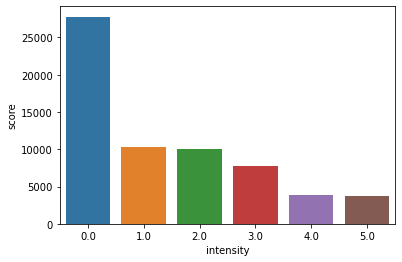

In [13]:
sns.barplot(data=y_bp_df1,x='intensity',y='score')

In [14]:
# one hot encode the labels
y_df = pd.get_dummies(y,prefix='PDSI')

# view the new one hot encoded labels dataframe
print(y_df.head())

# view the occurences of different labels to verify
print(y_df['PDSI_0.0'].value_counts())
print(y_df['PDSI_1.0'].value_counts())
print(y_df['PDSI_2.0'].value_counts())
print(y_df['PDSI_3.0'].value_counts())
print(y_df['PDSI_4.0'].value_counts())
print(y_df['PDSI_5.0'].value_counts())

   PDSI_0.0  PDSI_1.0  PDSI_2.0  PDSI_3.0  PDSI_4.0  PDSI_5.0
0         0         1         0         0         0         0
1         0         1         0         0         0         0
2         1         0         0         0         0         0
3         1         0         0         0         0         0
4         1         0         0         0         0         0
0    35783
1    27785
Name: PDSI_0.0, dtype: int64
0    53197
1    10371
Name: PDSI_1.0, dtype: int64
0    53583
1     9985
Name: PDSI_2.0, dtype: int64
0    55846
1     7722
Name: PDSI_3.0, dtype: int64
0    59657
1     3911
Name: PDSI_4.0, dtype: int64
0    59774
1     3794
Name: PDSI_5.0, dtype: int64


In [15]:
# Normalizing the dataset
X_norm = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns)

# view the first 5 rows of the dataframe
print(X_norm.head())

    PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET   T2M_MAX  \
0  0.012368  0.925852  0.363263  0.343546  0.597658  0.591292  0.336442   
1  0.107869  0.917340  0.424361  0.365590  0.651653  0.645891  0.337408   
2  0.319828  0.911741  0.488723  0.382665  0.701241  0.696198  0.341340   
3  0.272138  0.910642  0.483388  0.381493  0.699545  0.694401  0.341495   
4  0.237434  0.910308  0.498203  0.389187  0.712535  0.707557  0.354926   

    T2M_MIN  T2M_RANGE        TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0  0.400992   0.427046  0.366207  0.201716   0.286604   0.211681     0.336436   
1  0.431559   0.371745  0.381523  0.233060   0.365411   0.197743     0.490780   
2  0.457937   0.330659  0.395543  0.225427   0.352744   0.197344     0.469699   
3  0.454101   0.338157  0.395062  0.221294   0.332175   0.196948     0.434517   
4  0.460260   0.354962  0.400073  0.214532   0.328494   0.188519     0.439262   

      WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  
0  0.258895  

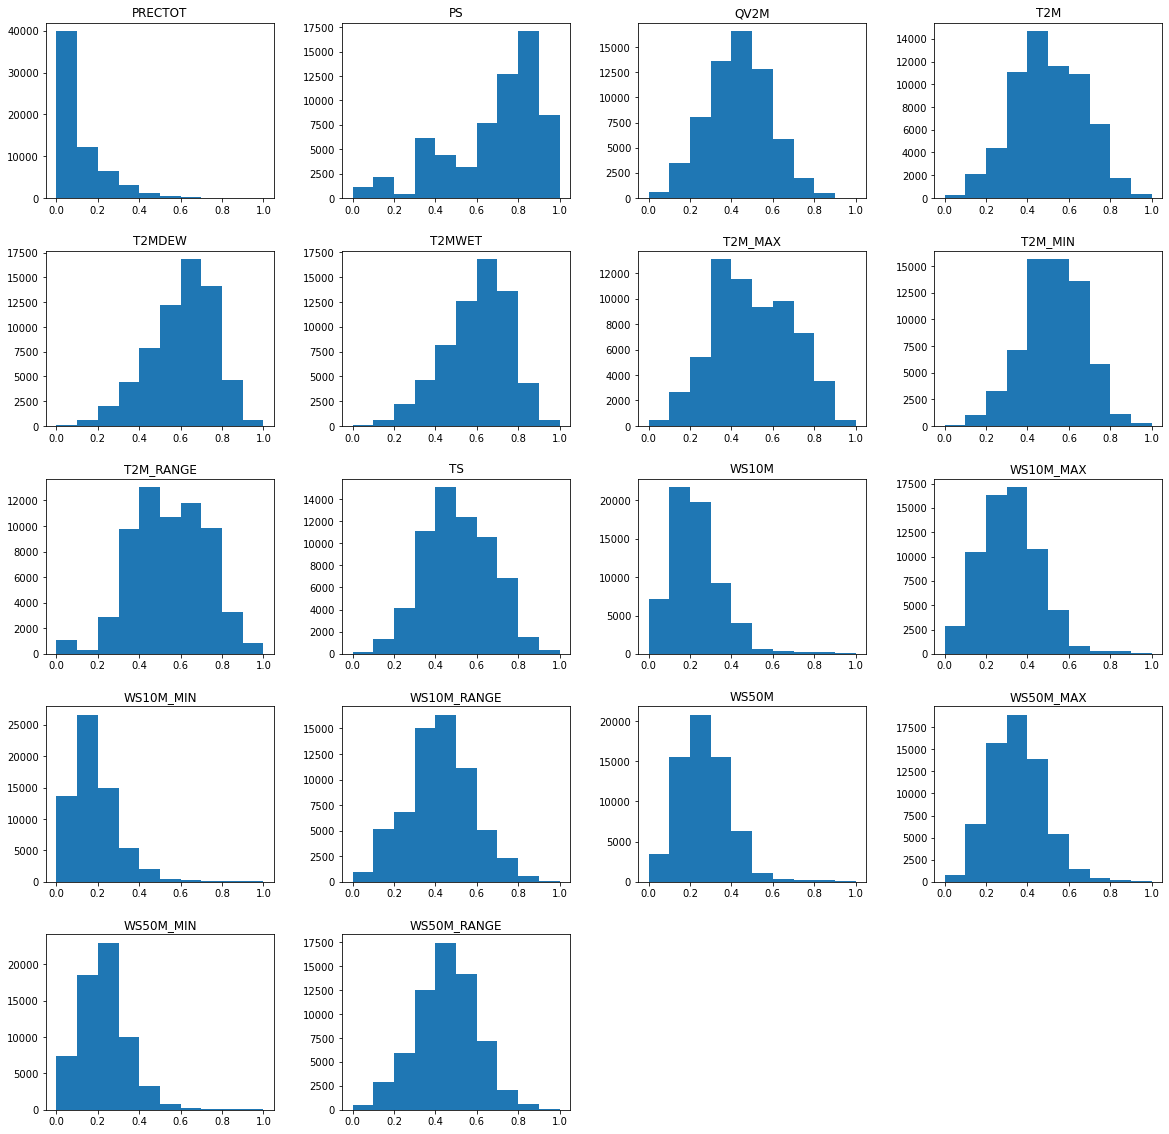

In [17]:
# plot distribution graphs of all the normalized features
X_norm.hist(figsize=(20,20),grid=False)
plt.show()

In [ ]:
sns.histplot(X_norm.

In [20]:
X_norm_corr = X_norm
X_norm_corr['score'] = y
print(X_norm_corr.head())
data = X_norm_corr
print(data.info())
data_corr = data.corr()
print(data_corr)

    PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET   T2M_MAX  \
0  0.012368  0.925852  0.363263  0.343546  0.597658  0.591292  0.336442   
1  0.107869  0.917340  0.424361  0.365590  0.651653  0.645891  0.337408   
2  0.319828  0.911741  0.488723  0.382665  0.701241  0.696198  0.341340   
3  0.272138  0.910642  0.483388  0.381493  0.699545  0.694401  0.341495   
4  0.237434  0.910308  0.498203  0.389187  0.712535  0.707557  0.354926   

    T2M_MIN  T2M_RANGE        TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0  0.400992   0.427046  0.366207  0.201716   0.286604   0.211681     0.336436   
1  0.431559   0.371745  0.381523  0.233060   0.365411   0.197743     0.490780   
2  0.457937   0.330659  0.395543  0.225427   0.352744   0.197344     0.469699   
3  0.454101   0.338157  0.395062  0.221294   0.332175   0.196948     0.434517   
4  0.460260   0.354962  0.400073  0.214532   0.328494   0.188519     0.439262   

      WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0  0.2

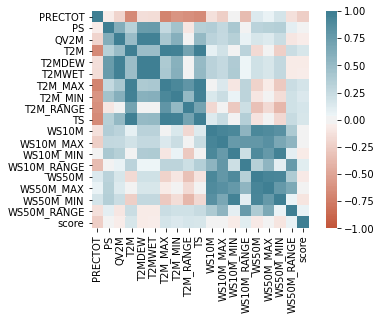

In [23]:
ax = sns.heatmap(data_corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,n=200),square=True)

In [25]:
upper_tri = data_corr.where(np.triu(np.ones(data_corr.shape),k=1).astype(np.bool))
print(upper_tri)

             PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET  \
PRECTOT          NaN -0.048007 -0.204288 -0.666130 -0.146719 -0.151690   
PS               NaN       NaN  0.616927  0.331619  0.755998  0.759470   
QV2M             NaN       NaN       NaN  0.506584  0.972135  0.972155   
T2M              NaN       NaN       NaN       NaN  0.489889  0.493620   
T2MDEW           NaN       NaN       NaN       NaN       NaN  0.999557   
T2MWET           NaN       NaN       NaN       NaN       NaN       NaN   
T2M_MAX          NaN       NaN       NaN       NaN       NaN       NaN   
T2M_MIN          NaN       NaN       NaN       NaN       NaN       NaN   
T2M_RANGE        NaN       NaN       NaN       NaN       NaN       NaN   
TS               NaN       NaN       NaN       NaN       NaN       NaN   
WS10M            NaN       NaN       NaN       NaN       NaN       NaN   
WS10M_MAX        NaN       NaN       NaN       NaN       NaN       NaN   
WS10M_MIN        NaN       NaN       N

In [26]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'TS', 'WS50M_MIN']


In [8]:
# split the features and labels dataframe into training and testing dataset
xtrain , xtest , ytrain, ytest = train_test_split(X_norm,y_df['PDSI_0.0'], random_state = 42, test_size = 0.30, shuffle = True)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(44497, 18)
(19071, 18)
(44497,)
(19071,)


In [34]:
X_norm_d = X_norm.drop(columns = to_drop, axis=1)
X_norm_d = X_norm_d.drop(columns = ['score'], axis=1)
print(X_norm_d.head())

    PRECTOT        PS      QV2M       T2M  T2M_RANGE     WS10M  WS10M_MAX  \
0  0.012368  0.925852  0.363263  0.343546   0.427046  0.201716   0.286604   
1  0.107869  0.917340  0.424361  0.365590   0.371745  0.233060   0.365411   
2  0.319828  0.911741  0.488723  0.382665   0.330659  0.225427   0.352744   
3  0.272138  0.910642  0.483388  0.381493   0.338157  0.221294   0.332175   
4  0.237434  0.910308  0.498203  0.389187   0.354962  0.214532   0.328494   

   WS10M_MIN  WS10M_RANGE     WS50M  WS50M_MAX  WS50M_RANGE  
0   0.211681     0.336436  0.258895   0.319971     0.358597  
1   0.197743     0.490780  0.308030   0.418415     0.524618  
2   0.197344     0.469699  0.305886   0.398887     0.476670  
3   0.196948     0.434517  0.300952   0.388052     0.457115  
4   0.188519     0.439262  0.291547   0.382656     0.463321  


In [35]:
xtraind, xtestd, ytraind, ytestd = train_test_split(X_norm_d, y_df['PDSI_0.0'], random_state = 42, test_size = 0.30, shuffle = True)
print(xtraind.shape)
print(xtestd.shape)
print(ytraind.shape)
print(ytestd.shape)

(44497, 12)
(19071, 12)
(44497,)
(19071,)


In [9]:
# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(xtrain)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train, y_train = xtrain[mask, :], ytrain[mask]
# # summarize the shape of the updated training dataset
# print(xtrain.shape, ytrain.shape)

In [9]:
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

# # f_importances(svm.coef_, features_names)

# SVM

In [10]:
# Train an SVM model
# define an svm model and fit on xtrain and ytrain
svm_classifier = svm.SVC(kernel='rbf', C=2 ,gamma='scale')
svm_classifier.fit(xtrain, ytrain)

# predict with the help of trained svm model
y_pred_svm = svm_classifier.predict(xtest)

In [11]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_svm))
print("f1_score:", f1_score(ytest,y_pred_svm,average = 'micro'))
print(classification_report(ytest,y_pred_svm))

accuracy_score: 0.7193120444654187
f1_score: 0.7193120444654189
              precision    recall  f1-score   support

           0       0.71      0.85      0.77     10731
           1       0.74      0.55      0.63      8340

    accuracy                           0.72     19071
   macro avg       0.73      0.70      0.70     19071
weighted avg       0.72      0.72      0.71     19071



# Logistic Regression

In [13]:
# LogReg_clf = LogisticRegression(random_state = 0, max_iter=15000, solver='saga',penalty='elasticnet',l1_ratio=1) #0.7118661842588223
# LogReg_clf = LogisticRegression(random_state = 0, max_iter=10000, solver='liblinear',penalty='l1') 0.7112893922709873

# Train a Logistic Regression model
# define an logistic regression model and fit on xtrain and ytrain
LogReg_classifier = LogisticRegression(random_state = 0, max_iter=500, solver='lbfgs',penalty='none') # 0.7124954118819149
LogReg_classifier.fit(xtrain, ytrain)

# predict with the help of trained logistic regression model
y_pred_lr = LogReg_classifier.predict(xtest)

In [14]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_lr))
print("f1_score:", f1_score(ytest,y_pred_lr,average = 'micro'))
print(classification_report(ytest,y_pred_lr))

accuracy_score: 0.6820827434324367
f1_score: 0.6820827434324367
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     10731
           1       0.69      0.50      0.58      8340

    accuracy                           0.68     19071
   macro avg       0.68      0.66      0.66     19071
weighted avg       0.68      0.68      0.67     19071



# XGBOOST

In [15]:
# Train an XGBoost model
# define an XGBoost model and fit on xtrain and ytrain
xgb_classifier = XGBClassifier() 

xgb_classifier.fit(xtrain, ytrain)

# predict with the help of trained XGBoost model
y_pred_xgb = xgb_classifier.predict(xtest)

In [16]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_xgb))
print("f1_score:", f1_score(ytest,y_pred_xgb,average = 'micro'))
print(classification_report(ytest,y_pred_xgb))

accuracy_score: 0.7758900949084998
f1_score: 0.7758900949084998
              precision    recall  f1-score   support

           0       0.77      0.85      0.81     10731
           1       0.78      0.68      0.73      8340

    accuracy                           0.78     19071
   macro avg       0.78      0.77      0.77     19071
weighted avg       0.78      0.78      0.77     19071



# KNeighborsClassifier

In [17]:
# Train an KNeighborsClassifier model
# define an KNeighborsClassifier model and fit on xtrain and ytrain
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(xtrain,ytrain)

# predict with the help of trained KNeighborsClassifier model
y_pred_knn = knn_classifier.predict(xtest)

In [18]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_knn))
print("f1_score:", f1_score(ytest,y_pred_knn,average = 'micro'))
print(classification_report(ytest,y_pred_knn))

accuracy_score: 0.8143254155524094
f1_score: 0.8143254155524094
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     10731
           1       0.80      0.77      0.78      8340

    accuracy                           0.81     19071
   macro avg       0.81      0.81      0.81     19071
weighted avg       0.81      0.81      0.81     19071



# RandomForestClassifier

In [10]:
# Train a RandomForestClassifier model
# define a RandomForestClassifier model and fit on xtrain and ytrain
randomf_classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
randomf_classifier.fit(xtrain,ytrain)

# predict with the help of trained KNeighborsClassifier model
y_pred_randomf = randomf_classifier.predict(xtest)

In [31]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_randomf))
print("f1_score:", f1_score(ytest,y_pred_randomf,average = 'micro'))
print(classification_report(ytest,y_pred_randomf))

accuracy_score: 0.8465733312359079
f1_score: 0.8465733312359078
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     10731
           1       0.86      0.78      0.82      8340

    accuracy                           0.85     19071
   macro avg       0.85      0.84      0.84     19071
weighted avg       0.85      0.85      0.85     19071



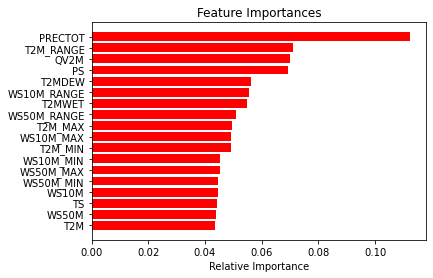

In [13]:
drought_features = X_norm.columns
feature_importances = randomf_classifier.feature_importances_
indices = np.argsort(feature_importances)[-18:]  # all 18 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [drought_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [36]:
# Train a RandomForestClassifier model
# define a RandomForestClassifier model and fit on xtrain and ytrain
randomf_classifierd = RandomForestClassifier(n_estimators = 1000, random_state = 42)
randomf_classifierd.fit(xtraind,ytraind)

# predict with the help of trained KNeighborsClassifier model
y_pred_randomfd = randomf_classifierd.predict(xtestd)

In [37]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytestd,y_pred_randomfd))
print("f1_score:", f1_score(ytestd,y_pred_randomfd,average = 'micro'))
print(classification_report(ytestd,y_pred_randomfd))

accuracy_score: 0.852760736196319
f1_score: 0.852760736196319
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     10731
           1       0.87      0.79      0.82      8340

    accuracy                           0.85     19071
   macro avg       0.85      0.85      0.85     19071
weighted avg       0.85      0.85      0.85     19071



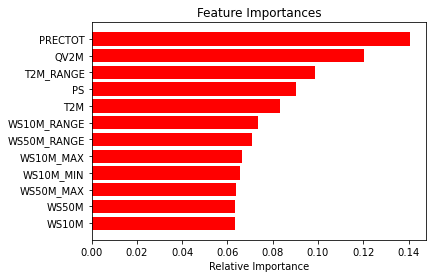

In [38]:
drought_features = X_norm_d.columns
feature_importances = randomf_classifierd.feature_importances_
indices = np.argsort(feature_importances)[-18:]  # all 18 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [drought_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [14]:
# Train a RandomForestClassifier model
# define a RandomForestClassifier model and fit on xtrain and ytrain
randomf_classifier1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
randomf_classifier1.fit(xtrain,ytrain)

# predict with the help of trained KNeighborsClassifier model
y_pred_randomf1 = randomf_classifier1.predict(xtest)

In [15]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_randomf1))
print("f1_score:", f1_score(ytest,y_pred_randomf1,average = 'micro'))
print(classification_report(ytest,y_pred_randomf1))

accuracy_score: 0.8432698862146715
f1_score: 0.8432698862146715
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     10731
           1       0.85      0.77      0.81      8340

    accuracy                           0.84     19071
   macro avg       0.85      0.84      0.84     19071
weighted avg       0.84      0.84      0.84     19071



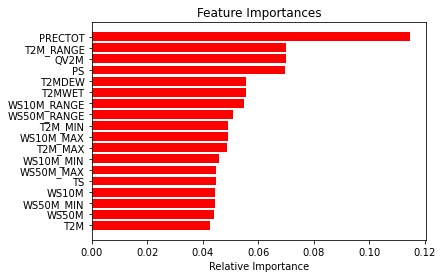

In [16]:
drought_features = X_norm.columns
feature_importances = randomf_classifier1.feature_importances_
indices = np.argsort(feature_importances)[-18:]  # all 18 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [drought_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
# Train a RandomForestClassifier model
# define a RandomForestClassifier model and fit on xtrain and ytrain
randomf_classifier2 = RandomForestClassifier(n_estimators = 500, random_state = 42)
randomf_classifier2.fit(xtrain,ytrain)

# predict with the help of trained KNeighborsClassifier model
y_pred_randomf2 = randomf_classifier2.predict(xtest)

In [18]:
# view various evaluation matrices
print("accuracy_score:", accuracy_score(ytest,y_pred_randomf2))
print("f1_score:", f1_score(ytest,y_pred_randomf2,average = 'micro'))
print(classification_report(ytest,y_pred_randomf2))

accuracy_score: 0.8463111530596193
f1_score: 0.8463111530596193
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     10731
           1       0.85      0.78      0.82      8340

    accuracy                           0.85     19071
   macro avg       0.85      0.84      0.84     19071
weighted avg       0.85      0.85      0.85     19071



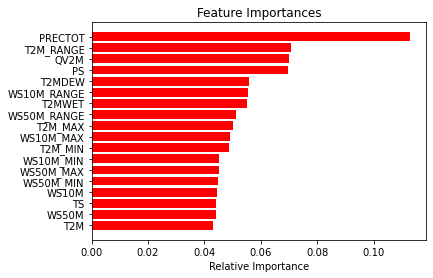

In [19]:
drought_features = X_norm.columns
feature_importances = randomf_classifier2.feature_importances_
indices = np.argsort(feature_importances)[-18:]  # all 18 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [drought_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# VotingEnsemble

In [48]:
# Train an KNeighborsClassifier model
# import VotingClassifier
from sklearn.ensemble import VotingClassifier

# make a list of models to be used for ensemble
# estimators=[('ann', KerasClassifier(build_fn = create_baseline, epochs = 10, batch_size = 5, verbose = 0)), ('svm', svm.SVC(kernel='rbf', C=2 ,gamma='scale')), ('log_reg', LogisticRegression(random_state = 0, max_iter=500, solver='lbfgs',penalty='none'))]
estimators = [('rff1',RandomForestClassifier(n_estimators = 100, random_state = 42)),('rff2',RandomForestClassifier(n_estimators = 500, random_state = 42)),('rff3',RandomForestClassifier(n_estimators = 500, random_state = 42))]

# define a VotingClassifier model and fit on xtrain and ytrain
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(xtrain, ytrain)

In [ ]:
# predict with the help of trained VotingClassifier model
y_pred_ensemble = ensemble.predict(xtest)

In [ ]:
# evaluating f1-score
print("accuracy_score:", accuracy_score(ytest,y_pred_ensemble))
print("f1_score:", f1_score(ytest,y_pred_ensemble,average = 'micro'))
print(classification_report(ytest,y_pred_ensemble))

# Predicting Intensities

In [57]:
from sklearn.multiclass import OneVsRestClassifier

In [58]:
cal_df1 = cal_90d_agg
cal_df1.score = cal_df1.score.round()
cal_df2 = cal_df1[cal_df1.score>0]
print(cal_df2.head())

      fips   PRECTOT          PS      QV2M        T2M    T2MDEW    T2MWET  \
0   6001.0  0.196000  100.487000  5.158000   7.692000  3.782000  3.810000   
1   6001.0  1.709412  100.257059  5.701765   8.592941  5.245294  5.262941   
76  6001.0  0.445778   99.451333  6.483222  16.751444  7.112889  7.130111   
77  6001.0  0.453222   99.458556  6.546222  17.416000  7.258556  7.275667   
80  6001.0  0.028222   99.385000  6.914667  19.665222  8.088222  8.104667   

      T2M_MAX    T2M_MIN  T2M_RANGE         TS     WS10M  WS10M_MAX  \
0   13.969000   3.687000  10.283000   7.392000  2.666000   4.207000   
1   14.011176   4.871765   9.138824   8.114706  2.854706   4.770588   
76  26.260222   9.113000  17.146556  18.069556  4.038667   6.016444   
77  27.095444   9.567111  17.527778  18.857222  4.037889   6.067778   
80  30.030333  11.406556  18.623667  21.508222  4.329667   6.305000   

    WS10M_MIN  WS10M_RANGE     WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0    1.488000     2.719000  4

In [59]:
X_int = cal_df2.drop(columns=['fips','score'])
print(X_int.head())

     PRECTOT          PS      QV2M        T2M    T2MDEW    T2MWET    T2M_MAX  \
0   0.196000  100.487000  5.158000   7.692000  3.782000  3.810000  13.969000   
1   1.709412  100.257059  5.701765   8.592941  5.245294  5.262941  14.011176   
76  0.445778   99.451333  6.483222  16.751444  7.112889  7.130111  26.260222   
77  0.453222   99.458556  6.546222  17.416000  7.258556  7.275667  27.095444   
80  0.028222   99.385000  6.914667  19.665222  8.088222  8.104667  30.030333   

      T2M_MIN  T2M_RANGE         TS     WS10M  WS10M_MAX  WS10M_MIN  \
0    3.687000  10.283000   7.392000  2.666000   4.207000   1.488000   
1    4.871765   9.138824   8.114706  2.854706   4.770588   1.411765   
76   9.113000  17.146556  18.069556  4.038667   6.016444   2.363889   
77   9.567111  17.527778  18.857222  4.037889   6.067778   2.342667   
80  11.406556  18.623667  21.508222  4.329667   6.305000   2.667000   

    WS10M_RANGE     WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  
0      2.719000  4.001000   5

In [70]:
X_int_norm = pd.DataFrame(MinMaxScaler().fit_transform(X_int),columns=X_int.columns)
print(X_int_norm.head())

    PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET   T2M_MAX  \
0  0.015957  0.941229  0.363263  0.343546  0.597658  0.591292  0.336442   
1  0.139168  0.932576  0.424361  0.365590  0.651653  0.645891  0.337408   
2  0.036292  0.902253  0.512166  0.565207  0.720566  0.716055  0.617858   
3  0.036898  0.902525  0.519245  0.581467  0.725941  0.721525  0.636981   
4  0.002298  0.899757  0.560644  0.636499  0.756555  0.752677  0.704177   

    T2M_MIN  T2M_RANGE        TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0  0.400992   0.426084  0.366207  0.202370   0.281593   0.213717     0.331228   
1  0.431559   0.370691  0.381523  0.233815   0.360953   0.199645     0.486784   
2  0.540984   0.758370  0.592489  0.431105   0.536384   0.375400     0.558344   
3  0.552700   0.776826  0.609181  0.430976   0.543613   0.371482     0.576043   
4  0.600158   0.829882  0.665362  0.479596   0.577016   0.431352     0.554934   

      WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  
0  0.258895  

In [81]:
y_int = cal_df2.score.astype(int)
y_int = y_int.reset_index(drop=True)
print(y_int)

0        1
1        1
2        1
3        1
4        1
        ..
35778    3
35779    3
35780    3
35781    3
35782    3
Name: score, Length: 35783, dtype: int32


In [82]:
X_int_norm_corr = X_int_norm
X_int_norm_corr['score'] = y_int
print(X_int_norm_corr.head())
data_int = X_int_norm_corr
print(data_int.info())
data_int_corr = data_int.corr()
print(data_int_corr)

    PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET   T2M_MAX  \
0  0.015957  0.941229  0.363263  0.343546  0.597658  0.591292  0.336442   
1  0.139168  0.932576  0.424361  0.365590  0.651653  0.645891  0.337408   
2  0.036292  0.902253  0.512166  0.565207  0.720566  0.716055  0.617858   
3  0.036898  0.902525  0.519245  0.581467  0.725941  0.721525  0.636981   
4  0.002298  0.899757  0.560644  0.636499  0.756555  0.752677  0.704177   

    T2M_MIN  T2M_RANGE        TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0  0.400992   0.426084  0.366207  0.202370   0.281593   0.213717     0.331228   
1  0.431559   0.370691  0.381523  0.233815   0.360953   0.199645     0.486784   
2  0.540984   0.758370  0.592489  0.431105   0.536384   0.375400     0.558344   
3  0.552700   0.776826  0.609181  0.430976   0.543613   0.371482     0.576043   
4  0.600158   0.829882  0.665362  0.479596   0.577016   0.431352     0.554934   

      WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0  0.2

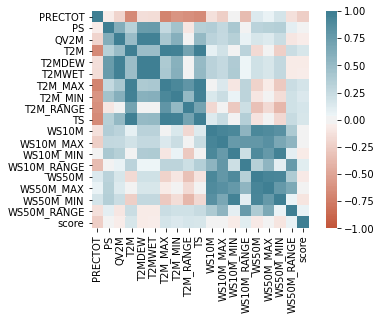

In [83]:
ax_int = sns.heatmap(data_corr,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,n=200),square=True)

In [84]:
upper_tri_int = data_int_corr.where(np.triu(np.ones(data_int_corr.shape),k=1).astype(np.bool))
print(upper_tri_int)

             PRECTOT        PS      QV2M       T2M    T2MDEW    T2MWET  \
PRECTOT          NaN -0.078086 -0.203595 -0.641178 -0.162894 -0.168035   
PS               NaN       NaN  0.622190  0.359349  0.754264  0.758071   
QV2M             NaN       NaN       NaN  0.511541  0.973008  0.973034   
T2M              NaN       NaN       NaN       NaN  0.510100  0.513945   
T2MDEW           NaN       NaN       NaN       NaN       NaN  0.999484   
T2MWET           NaN       NaN       NaN       NaN       NaN       NaN   
T2M_MAX          NaN       NaN       NaN       NaN       NaN       NaN   
T2M_MIN          NaN       NaN       NaN       NaN       NaN       NaN   
T2M_RANGE        NaN       NaN       NaN       NaN       NaN       NaN   
TS               NaN       NaN       NaN       NaN       NaN       NaN   
WS10M            NaN       NaN       NaN       NaN       NaN       NaN   
WS10M_MAX        NaN       NaN       NaN       NaN       NaN       NaN   
WS10M_MIN        NaN       NaN       N

In [85]:
to_drop_int = [column for column in upper_tri_int.columns if any(upper_tri_int[column] > 0.95)]
print(to_drop_int)

['T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'TS', 'WS50M_MIN']


In [86]:
X_norm_int_d = X_int_norm.drop(columns = to_drop, axis=1)
X_norm_int_d = X_norm_int_d.drop(columns = ['score'], axis=1)
print(X_norm_int_d.head())

    PRECTOT        PS      QV2M       T2M  T2M_RANGE     WS10M  WS10M_MAX  \
0  0.015957  0.941229  0.363263  0.343546   0.426084  0.202370   0.281593   
1  0.139168  0.932576  0.424361  0.365590   0.370691  0.233815   0.360953   
2  0.036292  0.902253  0.512166  0.565207   0.758370  0.431105   0.536384   
3  0.036898  0.902525  0.519245  0.581467   0.776826  0.430976   0.543613   
4  0.002298  0.899757  0.560644  0.636499   0.829882  0.479596   0.577016   

   WS10M_MIN  WS10M_RANGE     WS50M  WS50M_MAX  WS50M_RANGE  
0   0.213717     0.331228  0.258895   0.320270     0.349937  
1   0.199645     0.486784  0.308030   0.419278     0.518200  
2   0.375400     0.558344  0.452349   0.515711     0.461477  
3   0.371482     0.576043  0.441877   0.512391     0.478641  
4   0.431352     0.554934  0.464133   0.514380     0.416107  


In [72]:
# split the features and labels dataframe into training and testing dataset
xtrainm , xtestm , ytrainm, ytestm = train_test_split(X_int_norm,y_int, random_state = 42, test_size = 0.30, shuffle = True)

print(xtrainm.shape)
print(xtestm.shape)
print(ytrainm.shape)
print(ytestm.shape)

(25048, 18)
(10735, 18)
(25048,)
(10735,)


In [87]:
xtraind_int, xtestd_int, ytraind_int, ytestd_int = train_test_split(X_norm_int_d, y_int, random_state = 42, test_size = 0.30, shuffle = True)
print(xtraind_int.shape)
print(xtestd_int.shape)
print(ytraind_int.shape)
print(ytestd_int.shape)

(25048, 12)
(10735, 12)
(25048,)
(10735,)


In [88]:
ovr_svm_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42)).fit(xtrainm,ytrainm)

In [89]:
y_pred_ovr = ovr_svm_clf.predict(xtestm)

In [90]:
# evaluating f1-score
print("accuracy_score:", accuracy_score(ytestm,y_pred_ovr))
print("f1_score:", f1_score(ytestm,y_pred_ovr,average = 'micro'))
print(classification_report(ytestm,y_pred_ovr))

accuracy_score: 0.7224033535165347
f1_score: 0.7224033535165348
              precision    recall  f1-score   support

           1       0.72      0.77      0.75      3126
           2       0.67      0.75      0.71      2970
           3       0.71      0.71      0.71      2323
           4       0.81      0.57      0.67      1164
           5       0.84      0.71      0.77      1152

    accuracy                           0.72     10735
   macro avg       0.75      0.70      0.72     10735
weighted avg       0.73      0.72      0.72     10735



In [91]:
ovr_svm_clfd = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42)).fit(xtraind_int,ytraind_int)

In [92]:
y_pred_ovrd = ovr_svm_clfd.predict(xtestd_int)

In [93]:
# evaluating f1-score
print("accuracy_score:", accuracy_score(ytestd_int,y_pred_ovrd))
print("f1_score:", f1_score(ytestd_int,y_pred_ovrd,average = 'micro'))
print(classification_report(ytestd_int,y_pred_ovrd))

accuracy_score: 0.7308802980903586
f1_score: 0.7308802980903586
              precision    recall  f1-score   support

           1       0.73      0.78      0.75      3126
           2       0.68      0.76      0.72      2970
           3       0.71      0.72      0.71      2323
           4       0.82      0.60      0.69      1164
           5       0.87      0.71      0.78      1152

    accuracy                           0.73     10735
   macro avg       0.76      0.71      0.73     10735
weighted avg       0.74      0.73      0.73     10735



In [49]:
estimators_ovr = [('rff1',RandomForestClassifier(n_estimators = 100, random_state = 42)),('rff2',RandomForestClassifier(n_estimators = 500, random_state = 42)),('rff3',RandomForestClassifier(n_estimators = 500, random_state = 42))]

# define a VotingClassifier model and fit on xtrain and ytrain
ensemble_ovr = VotingClassifier(estimators_ovr, voting='soft')
ensemble_ovr.fit(xtrainm, ytrainm)

VotingClassifier(estimators=[('rff1', RandomForestClassifier(random_state=42)),
                             ('rff2',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42)),
                             ('rff3',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42))],
                 voting='soft')

In [50]:
# predict with the help of trained VotingClassifier model
y_pred_ensemble_ovr = ensemble_ovr.predict(xtestm)

In [51]:
# evaluating f1-score
print("accuracy_score:", accuracy_score(ytestm,y_pred_ensemble_ovr))
print("f1_score:", f1_score(ytestm,y_pred_ensemble_ovr,average = 'micro'))
print(classification_report(ytestm,y_pred_ensemble_ovr))

accuracy_score: 0.7328365160689334
f1_score: 0.7328365160689334
              precision    recall  f1-score   support

           1       0.73      0.78      0.76      3126
           2       0.67      0.76      0.71      2970
           3       0.73      0.72      0.73      2323
           4       0.83      0.60      0.69      1164
           5       0.86      0.70      0.77      1152

    accuracy                           0.73     10735
   macro avg       0.77      0.71      0.73     10735
weighted avg       0.74      0.73      0.73     10735

